In [15]:
import numpy as np
import nibabel as nib
from nibabel.affines import apply_affine
import os
import pandas as pd


In [16]:
# Get all surface files and sort them
surf_dir = 'raw_data/FreeSurfer_Surfaces/40_depths'
surf_files = sorted([f for f in os.listdir(surf_dir) if f.startswith('rh.equi')])

print(f"{len(surf_files)} surface files")
depths = len(surf_files)

# array to store every vertex coordinate
all_vertex_coords = []
# array of tuples to store each vertex unique identifier (vertex_id, depth)
all_vertex_labels = []

for depth_idx, surf_filename in enumerate(surf_files):
    surf_file = os.path.join(surf_dir, surf_filename)
    
    #print(f"Depth {depth_idx}: {surf_filename}")
    
    coords, faces, volume_info = nib.freesurfer.read_geometry(surf_file, read_metadata=True)
    cras = np.array(volume_info['cras'])
    scanner_ras = coords + cras
    
    all_vertex_coords.append(scanner_ras)
    
    labels = [(v_id, depth_idx) for v_id in range(len(coords))]
    all_vertex_labels.extend(labels)

all_vertex_coords = np.vstack(all_vertex_coords)

print(f"\nTotal vertices: {len(all_vertex_coords):,}")
print(f"Shape: {all_vertex_coords.shape}")
print(f"length of all_vertex_labels: {len(all_vertex_labels)}")

41 surface files

Total vertices: 10,222,489
Shape: (10222489, 3)
length of all_vertex_labels: 10222489


In [17]:
# Load volume
volume = nib.load('raw_data/RHoccip_SGcrop.nii.gz')
print(f"Volume shape: {volume.shape}")
print(f"Total voxels: {np.prod(volume.shape):,}")

# Create grid of all voxel indices

i, j, k = np.meshgrid(
    np.arange(volume.shape[0]),
    np.arange(volume.shape[1]),
    np.arange(volume.shape[2]),
    indexing='ij'
)

voxel_indices = np.column_stack([i.reshape(-1), j.reshape(-1), k.reshape(-1)])
print(f"Voxel indices shape: {voxel_indices.shape}")

# Transform to Scanner RAS using volume's affine
voxel_ras = apply_affine(volume.affine, voxel_indices)
print(f"Voxel RAS coordinates shape: {voxel_ras.shape}")

# Get intensities
intensities = volume.get_fdata().reshape(-1)
print(f"Intensities shape: {intensities.shape}")

Volume shape: (182, 274, 305)
Total voxels: 15,209,740
Voxel indices shape: (15209740, 3)
Voxel RAS coordinates shape: (15209740, 3)
Intensities shape: (15209740,)


In [26]:
SGmask = nib.load('raw_data/SG_mask_100um.nii.gz')
print(f"Volume Shape: {SGmask.shape}")
SGlabels = SGmask.get_fdata().reshape(-1)
print(f"labels shape: {SGlabels.shape}")



Volume Shape: (182, 274, 305)
labels shape: (15209740,)


In [19]:
from scipy.spatial import cKDTree

vertex_tree = cKDTree(all_vertex_coords)

print(f"Tree contains {vertex_tree.n} points")

print(f"No. of voxels to query: {len(voxel_ras)}")

# Find nearest vertex for each voxel
distances, nearest_vertex_global_idx = vertex_tree.query(voxel_ras, k=1)

print(f"nearest_vertex_global_idx shape: {nearest_vertex_global_idx.shape}")

Tree contains 10222489 points
No. of voxels to query: 15209740
nearest_vertex_global_idx shape: (15209740,)


In [ ]:
# Extract vertex_id and depth from global indices
all_vertex_labels_array = np.array(all_vertex_labels)
voxel_vertex_ids = all_vertex_labels_array[nearest_vertex_global_idx, 0]
voxel_depths = all_vertex_labels_array[nearest_vertex_global_idx, 1]

# create table
df = pd.DataFrame({
    'vertex_id': voxel_vertex_ids,
    'depth': voxel_depths,
    'intensity': intensities,
    'label': SGlabels
})

# Resolve SGlabels per vertex
def resolve_label(SGlabels):
    nonzero = SGlabels[SGlabels != 0]
    if len(nonzero) == 0:
        return 0
    if set(nonzero) == {1, 2}:  # Conflict
        return 1 if (nonzero == 1).sum() > (nonzero == 2).sum() else 2
    return int(nonzero.iloc[0])

vertex_labels_series = df.groupby('vertex_id')['label'].agg(resolve_label)

# Build profiles
profiles = df.groupby(['vertex_id', 'depth'])['intensity'].median().unstack()

# Combine
profiles['label'] = profiles.index.map(vertex_labels_series).fillna(0).astype(int)

print(profiles.head())

depth           0   1   2   3   4   5   6   7   8   9  ...  32  33  34  35  \
vertex_id                                              ...                   
525        3411.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
540        4267.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
584         552.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
585         565.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
598        1125.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

depth      36  37  38  39  40  label  
vertex_id                             
525       NaN NaN NaN NaN NaN      0  
540       NaN NaN NaN NaN NaN      0  
584       NaN NaN NaN NaN NaN      0  
585       NaN NaN NaN NaN NaN      0  
598       NaN NaN NaN NaN NaN      0  

[5 rows x 42 columns]


In [23]:
print(len(df))

15209740


Total labeled profiles: 4914
  SG (label=1): 2912
  Non-SG (label=2): 2002


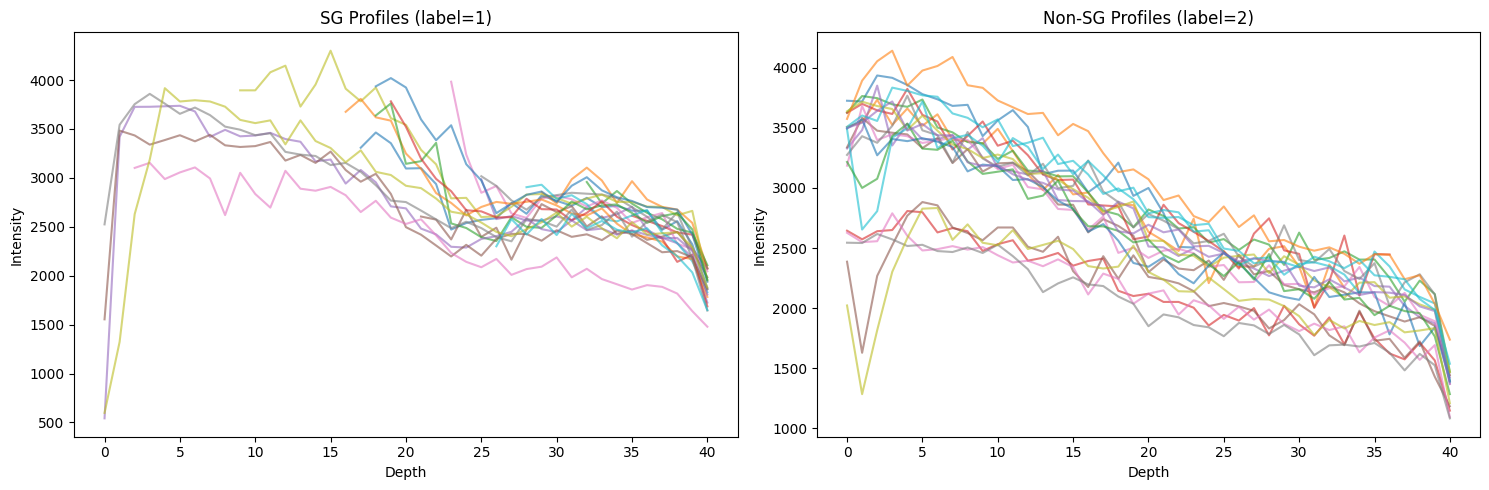

In [21]:
import matplotlib.pyplot as plt

# Get labeled profiles
labeled_profiles = profiles[profiles['label'] != 0].copy()

print(f"Total labeled profiles: {len(labeled_profiles)}")
print(f"  SG (label=1): {(labeled_profiles['label'] == 1).sum()}")
print(f"  Non-SG (label=2): {(labeled_profiles['label'] == 2).sum()}")

# Plot first 20 SG profiles
sg_profiles = labeled_profiles[labeled_profiles['label'] == 1]
depth_cols = list(range(41))  # Depths 0-40

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# SG profiles
for i, (vertex_id, row) in enumerate(sg_profiles.head(20).iterrows()):
    intensities = row[depth_cols].values
    ax1.plot(intensities, alpha=0.6, label=f'v{vertex_id}')
ax1.set_title('SG Profiles (label=1)')
ax1.set_xlabel('Depth')
ax1.set_ylabel('Intensity')

# Non-SG profiles
non_sg_profiles = labeled_profiles[labeled_profiles['label'] == 2]
for i, (vertex_id, row) in enumerate(non_sg_profiles.head(20).iterrows()):
    intensities = row[depth_cols].values
    ax2.plot(intensities, alpha=0.6, label=f'v{vertex_id}')
ax2.set_title('Non-SG Profiles (label=2)')
ax2.set_xlabel('Depth')
ax2.set_ylabel('Intensity')

plt.tight_layout()
plt.show()

In [ ]:

# Extract middle depths (6-34)
middle_depths = list(range(6, 35))

# Create feature_df
feature_df = profiles[middle_depths].copy()
feature_df.insert(0, 'col_id', profiles.index)  # Add vertex_id as 'col_id' column

# Remove vertices with any NaN in middle depths
n_before = len(feature_df)
feature_df = feature_df.dropna(subset=middle_depths)
n_after = len(feature_df)

print(f"Vertices before filtering: {n_before}")
print(f"Vertices after filtering: {n_after}")
print(f"Removed {n_before - n_after} vertices with incomplete profiles")

# Create label_dict
label_dict = profiles['label'].to_dict()


Vertices before filtering: 11640
Vertices after filtering: 9456
Removed 2184 vertices with incomplete profiles


In [ ]:
from src.classifier_training import (
    prepare_training_data,
    train_rf_model,
    predict_sg_probabilities,
    evaluate_model,
    cross_validate_auc
)
from src.extract_features import compute_features

X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_training_data(
    feature_df, 
    label_dict, 
    features_to_use=None)

In [30]:
rf_model = train_rf_model(X_train_scaled, y_train)

In [31]:
preds, probs = evaluate_model(rf_model, X_test_scaled, y_test, model_name = 'rf')
auc_scores = cross_validate_auc(rf_model, X_train_scaled, y_train)


Evaluation for rf
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      1883
           1       0.72      0.71      0.71      1130
           2       0.34      0.49      0.40       770

    accuracy                           0.59      3783
   macro avg       0.58      0.58      0.57      3783
weighted avg       0.62      0.59      0.60      3783



ValueError: multi_class must be in ('ovo', 'ovr')